### This notebook computes the joint likelihood in 5 dimensions for the parameters of interest (see below). See inference_demo for more details about basic usage

In [1]:
from lenslikelihood.measurements import flux_measurements, flux_measurement_uncertainties, all_lens_names, all_param_ranges

# Note that the syntax for the uncertainties is
# {'lens_name': (1-sigma-uncertainty, reference_index, uncertainty_in_ratio)}
# where reference_index is the reference image with which to compute the flux ratio, and uncertainty_in_ratio specifies
# whether the measurement uncertainty refers to the flux or the flux ratio

for name in all_lens_names:
    print(name)
    print('fluxes/flux ratios measured: ', flux_measurements[name])
    print('uncertainties: ', flux_measurement_uncertainties[name])
    print('\n')

B1422
fluxes/flux ratios measured:  [0.88  1.    0.474 0.025]
uncertainties:  ([0.011363636363636364, 0.01, 0.012765957446808512, None], 0, False)


HE0435
fluxes/flux ratios measured:  [0.96  0.976 1.    0.65 ]
uncertainties:  ([0.05, 0.049, 0.048, 0.056], 0, False)


WGD2038
fluxes/flux ratios measured:  [0.86 1.   0.79 0.4 ]
uncertainties:  ([0.01, 0.01724137931034483, 0.021739130434782608, 0.021739130434782608], 0, False)


WGDJ0405
fluxes/flux ratios measured:  [0.8  0.52 1.   0.94]
uncertainties:  ([0.04, 0.061538461538461535, 0.024, 0.03418803418803419], 0, False)


WFI2033
fluxes/flux ratios measured:  [1.   0.65 0.5  0.53]
uncertainties:  ([0.03, 0.046875, 0.04, 0.03773584905660377], 0, False)


PSJ1606
fluxes/flux ratios measured:  [1.   1.   0.59 0.79]
uncertainties:  ([0.03, 0.03, 0.03333333333333333, 0.02564102564102564], 0, False)


WFI2026
fluxes/flux ratios measured:  [1.   0.75 0.31 0.28]
uncertainties:  ([0.02, 0.02666666666666667, 0.06451612903225806, 0.0357142857142

### Models implemented for the halo mass function and concentration-mass relation

The full set of hyper-parameters we're interested in constraining are defined by the parameterizations of the halo mass function and concentration-mass relation. They are $\Sigma_{\rm{sub}}$, $\delta_{\rm{LOS}}$, $\Delta \alpha$, $q$, $c_8$, and $\beta$. The first four define to the subhalo and field halo mass functions, and the last two define the concentration-mass relation. 

The field halo mass function is parameterized as
\begin{equation}
\frac{dN_{\rm{LOS}}}{dm dV} = \delta_{\rm{LOS}} \left(1+\xi_{\rm{2halo}}\right) \left(\frac{m}{10^8}\right)^{\Delta \alpha} \ \frac{dN_{\rm{ShethTormen}}}{dm dV}
\end{equation}
where $\delta_{\rm{LOS}}$ scales the overall normalization, and $\Delta \alpha$ parameterizes deviations from the logarithmic slope predicted by CDM around $10^8 M_{\odot}$. 

The subhalo mass function is parameterized as
\begin{equation}
\frac{dN_{\rm{sub}}}{dm dA} \sim \Sigma_{\rm{sub}} \ \left(\frac{m}{10^8}\right)^{\alpha + q \Delta \alpha}
\end{equation}
where $\Sigma_{\rm{sub}}$ is the normalization, $\alpha$ is the logarithmic slope predicted by CDM, $\Delta \alpha$ parameterizes deviations from the value predicted by CDM, and $q$ controls the coupling between the line of sight halo mass function slope and the subhalo mass function slope. When $q=1$ the slopes change in the same way, and when $q=0$ the slopes of the subhalo and field halo mass functions are completely decoupled. 

The concentration-mass relation is parameterized as 

\begin{equation}
c\left(M, z\right) = c_8 \left(1+z\right)^{\zeta} \left(\frac{\nu\left(M, z\right)}{\nu\left(10^8, z\right)}\right)^{-\beta}
\end{equation}
i.e. it is a power-law in the peak height $\nu$ with normalization $c_8$ at $10^8$ and a logarithmic slope $\beta$. The parameter $\zeta$ modifies the redshift evolution and is marginalized over in the sampling. 

The parameter names used in the python code have the following correspondence: 


1) sigma_sub = $\Sigma_{\rm{sub}}$

2) delta_power_law_index = $\Delta \alpha$

3) c0 = $c_8$

4) beta = $\beta$

5) delta_power_law_index_coupling = $q$

6) LOS_normalization = $\delta_{\rm{LOS}}$

### Example inference on three parameters with a subset of lenses

First load the model samples, define what parameters we want to look at

In [2]:
import pickle
import matplotlib.pyplot as plt
# specify the parameter names
param_names = ['sigma_sub', 'LOS_normalization', 'beta', 'c0', 'delta_power_law_index']
param_ranges = [all_param_ranges[name] for name in param_names]
# specify the lenses to use
lenses = all_lens_names
raw_samples_dict = {}
# load the forward model samples
for lens in lenses:
    print(lens)
    f = open('./../raw_samples/'+lens, 'rb')
    raw_samples = pickle.load(f)
    f.close()
    raw_samples_dict[lens] = raw_samples

B1422
HE0435
WGD2038
WGDJ0405
WFI2033
PSJ1606
WFI2026
RXJ0911
RXJ1131
MG0414
PG1115
B0128


The next cell computes the joint likelihood without any importance sampling weights.

/Users/danielgilman/Code/lenslikelihood/lenslikelihood/extract_raw_samples.py:133: RuntimeWarning: divide by zero encountered in true_divide
  fr = fluxes[row, :] / fluxes[row, flux_ratio_index]
/Users/danielgilman/Code/lenslikelihood/lenslikelihood/extract_raw_samples.py:133: RuntimeWarning: invalid value encountered in true_divide
  fr = fluxes[row, :] / fluxes[row, flux_ratio_index]
/Users/danielgilman/Code/lenslikelihood/lenslikelihood/extract_raw_samples.py:121: RuntimeWarning: invalid value encountered in add
  fluxes_perturbed[:, i] = fluxes[:, i] + df


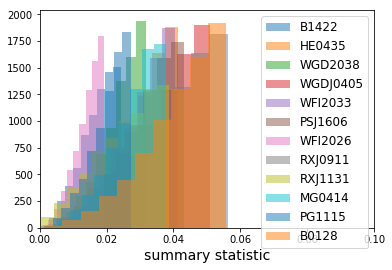

In [3]:
# compute the summary statistics, retaining the 1500 sets of model parameters with lowest summary statistic
n_samples_keep = 1500
samples_dict = {}
full_samples_dict = {}

for lens in lenses:
    
    importance_sampling_weights = None
    measured_fluxes = flux_measurements[lens]
    measurement_uncertainties = flux_measurement_uncertainties[lens][0]
    reference_index = flux_measurement_uncertainties[lens][1]
    uncertaintiy_in_flux_ratios = flux_measurement_uncertainties[lens][2]
    
    samples, full_samples, statistic = raw_samples_dict[lens].sample_with_abc(flux_measurements[lens], 
                                                                   param_names, 
                                                                   measurement_uncertainties, 
                                                                   reference_index, 
                                                                   n_samples_keep,  
                                                                   uncertaintiy_in_ratios=uncertaintiy_in_flux_ratios,
                                                                   importance_sampling_weights=importance_sampling_weights)
    plt.hist(statistic, alpha=0.5, label=lens)
    samples_dict[lens] = samples
    full_samples_dict[lens] = full_samples

# the histogram shows the distribution of the retained summary statistics
plt.legend(fontsize=12)
plt.xlim(0., 0.1)
plt.xlabel('summary statistic', fontsize=14)
plt.show()

The next cell computes the joint likelihood with importance sampling weights, selecting only samples with delta_power_law_index_coupling (or 'q') close to 1. This makes the subhalo mass function track the slope of the field halo mass function, hence the name "coupled"

number of samples before importance sampling:  358720
number of samples after importance sampling:  112458
number of samples before importance sampling:  558680
number of samples after importance sampling:  175546
number of samples before importance sampling:  358720
number of samples after importance sampling:  112591
number of samples before importance sampling:  2650236
number of samples after importance sampling:  830954
number of samples before importance sampling:  502110
number of samples after importance sampling:  157367
number of samples before importance sampling:  358720
number of samples after importance sampling:  112291
number of samples before importance sampling:  358720
number of samples after importance sampling:  112533
number of samples before importance sampling:  675125
number of samples after importance sampling:  210733
number of samples before importance sampling:  2925250
number of samples after importance sampling:  916473
number of samples before importance

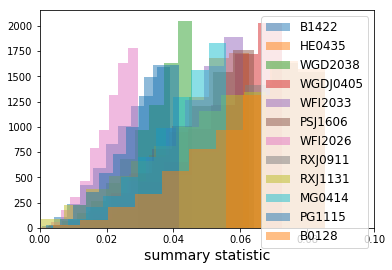

In [4]:
# compute the summary statistics, retaining the 1500 sets of model parameters with lowest summary statistic
samples_dict_coupled = {}
full_samples_dict_coupled = {}

for lens in lenses:
    
    importance_sampling_weights = {'delta_power_law_index_coupling': [1., 0.25]}
    measured_fluxes = flux_measurements[lens]
    measurement_uncertainties = flux_measurement_uncertainties[lens][0]
    reference_index = flux_measurement_uncertainties[lens][1]
    uncertaintiy_in_flux_ratios = flux_measurement_uncertainties[lens][2]
    samples, full_samples, statistic = raw_samples_dict[lens].sample_with_abc(flux_measurements[lens], 
                                                                   param_names, 
                                                                   measurement_uncertainties, 
                                                                   reference_index, 
                                                                   n_samples_keep,  
                                                                   uncertaintiy_in_ratios=uncertaintiy_in_flux_ratios,
                                                                   importance_sampling_weights=importance_sampling_weights)
    plt.hist(statistic, alpha=0.5, label=lens)
    samples_dict_coupled[lens] = samples
    full_samples_dict_coupled[lens] = full_samples

# the histogram shows the distribution of the retained summary statistics
plt.legend(fontsize=12)
plt.xlim(0., 0.1)
plt.xlabel('summary statistic', fontsize=14)
plt.show()

The next cell computes the joint likelihood with importance sampling weights, selecting only samples with delta_power_law_index_coupling (or 'q') close to 0. This makes the subhalo mass function decoupled from the slope of the field halo mass function, hence the name "decoupled"

number of samples before importance sampling:  358720
number of samples after importance sampling:  112668
number of samples before importance sampling:  558680
number of samples after importance sampling:  174692
number of samples before importance sampling:  358720
number of samples after importance sampling:  112428
number of samples before importance sampling:  2650236
number of samples after importance sampling:  831454
number of samples before importance sampling:  502110
number of samples after importance sampling:  157322
number of samples before importance sampling:  358720
number of samples after importance sampling:  112810
number of samples before importance sampling:  358720
number of samples after importance sampling:  112192
number of samples before importance sampling:  675125
number of samples after importance sampling:  211998
number of samples before importance sampling:  2925250
number of samples after importance sampling:  916106
number of samples before importance

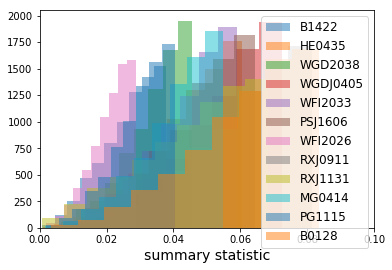

In [5]:
# compute the summary statistics, retaining the 1500 sets of model parameters with lowest summary statistic
samples_dict_decoupled = {}
full_samples_dict_decoupled = {}

for lens in lenses:
    
    importance_sampling_weights = {'delta_power_law_index_coupling': [0., 0.25]}
    measured_fluxes = flux_measurements[lens]
    measurement_uncertainties = flux_measurement_uncertainties[lens][0]
    reference_index = flux_measurement_uncertainties[lens][1]
    uncertaintiy_in_flux_ratios = flux_measurement_uncertainties[lens][2]
    samples, full_samples, statistic = raw_samples_dict[lens].sample_with_abc(flux_measurements[lens], 
                                                                   param_names, 
                                                                   measurement_uncertainties, 
                                                                   reference_index, 
                                                                   n_samples_keep,  
                                                                   uncertaintiy_in_ratios=uncertaintiy_in_flux_ratios,
                                                                   importance_sampling_weights=importance_sampling_weights)
    plt.hist(statistic, alpha=0.5, label=lens)
    samples_dict_decoupled[lens] = samples
    full_samples_dict_decoupled[lens] = full_samples

# the histogram shows the distribution of the retained summary statistics
plt.legend(fontsize=12)
plt.xlim(0., 0.1)
plt.xlabel('summary statistic', fontsize=14)
plt.show()

The likelihoods displayed in the previous cells include a marginalization over the amplitude $a_4$ of an octopole mass moment that results in boxy or disky isodensity contours. To analyze how much of an effect this has on the results, we can do importance sampling to select only realizations with low $a_4$ amplitudes.

number of samples before importance sampling:  358720
number of samples after importance sampling:  251008
number of samples before importance sampling:  558680
number of samples after importance sampling:  395247
number of samples before importance sampling:  358720
number of samples after importance sampling:  249763
number of samples before importance sampling:  2650236
number of samples after importance sampling:  1153232
number of samples before importance sampling:  502110
number of samples after importance sampling:  284715
number of samples before importance sampling:  358720
number of samples after importance sampling:  235896
number of samples before importance sampling:  358720
number of samples after importance sampling:  251954
number of samples before importance sampling:  675125
number of samples after importance sampling:  363269
number of samples before importance sampling:  2925250
number of samples after importance sampling:  2069347
number of samples before importan

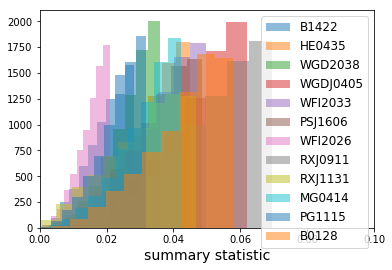

In [6]:
# compute the summary statistics, retaining the 1500 sets of model parameters with lowest summary statistic
samples_dict_lowa4 = {}
full_samples_dict_lowa4 = {}

for lens in lenses:
    
    importance_sampling_weights = {'a_m_1': [0., 0.01]}
    measured_fluxes = flux_measurements[lens]
    measurement_uncertainties = flux_measurement_uncertainties[lens][0]
    reference_index = flux_measurement_uncertainties[lens][1]
    uncertaintiy_in_flux_ratios = flux_measurement_uncertainties[lens][2]
    samples, full_samples, statistic = raw_samples_dict[lens].sample_with_abc(flux_measurements[lens], 
                                                                   param_names, 
                                                                   measurement_uncertainties, 
                                                                   reference_index, 
                                                                   n_samples_keep,  
                                                                   uncertaintiy_in_ratios=uncertaintiy_in_flux_ratios,
                                                                   importance_sampling_weights=importance_sampling_weights)
    plt.hist(statistic, alpha=0.5, label=lens)
    samples_dict_lowa4[lens] = samples
    full_samples_dict_lowa4[lens] = full_samples

# the histogram shows the distribution of the retained summary statistics
plt.legend(fontsize=12)
plt.xlim(0., 0.1)
plt.xlabel('summary statistic', fontsize=14)
plt.show()

Now we compute the likelihood using the package trikde https://github.com/dangilman/trikde

In [7]:
from trikde.pdfs import DensitySamples, IndepdendentLikelihoods
import os

nbins = 20
likelihoods, likelihoods_coupled, likelihoods_decoupled, likelihoods_lowa4 = [], [], [], []

load_from_pickle = False # if True, will look for a pre-computed DensitySamples class
save_to_pickle = True # if True, will pickle each class for accelerated later use; 
# save_to_pickle=True will do nothing if load_from_pickle=True

filename_extension = '_joint'
filename_extension_coupled = '_joint_coupled'
filename_extension_decoupled = '_joint_decoupled'
filename_extension_lowa4 = '_joint_lowa4'
base_path = './../lenslikelihood/precomputed_likelihoods/'

for lens in lenses:
    
    fname = base_path + lens + filename_extension
    if load_from_pickle and os.path.exists(fname):
        print('loading joint likelihoods for lens '+lens+' ...')
        f = open(fname, 'rb')
        single_lens_likelihood = pickle.load(f)
        f.close()
    else:
        print('computing joint likelihoods for lens '+lens+' ...')
        lens_samples = samples_dict[lens]
        weights = None
        single_lens_likelihood = DensitySamples(lens_samples, param_names, weights, 
                                 param_ranges, nbins=nbins, use_kde=True, bandwidth_scale=1.)
        if save_to_pickle:
            f = open(fname, 'wb')
            pickle.dump(single_lens_likelihood, f)
            f.close()
    likelihoods.append(single_lens_likelihood)
    
    fname = base_path + lens + filename_extension_coupled
    if load_from_pickle and os.path.exists(fname):
        f = open(fname, 'rb')
        single_lens_likelihood = pickle.load(f)
        f.close()
    else:
        lens_samples = samples_dict_coupled[lens]
        weights = None
        single_lens_likelihood = DensitySamples(lens_samples, param_names, weights, 
                                 param_ranges, nbins=nbins, use_kde=True, bandwidth_scale=1.)
        if save_to_pickle:
            f = open(fname, 'wb')
            pickle.dump(single_lens_likelihood, f)
            f.close()
    likelihoods_coupled.append(single_lens_likelihood)
    
    fname = base_path + lens + filename_extension_decoupled
    if load_from_pickle and os.path.exists(fname):
        f = open(fname, 'rb')
        single_lens_likelihood = pickle.load(f)
        f.close()
    else:
        lens_samples = samples_dict_decoupled[lens]
        weights = None
        single_lens_likelihood = DensitySamples(lens_samples, param_names, weights, 
                                 param_ranges, nbins=nbins, use_kde=True, bandwidth_scale=1.)
        if save_to_pickle:
            f = open(fname, 'wb')
            pickle.dump(single_lens_likelihood, f)
            f.close()
    likelihoods_decoupled.append(single_lens_likelihood)
    
    fname = base_path + lens + filename_extension_lowa4
    if load_from_pickle and os.path.exists(fname):
        f = open(fname, 'rb')
        single_lens_likelihood = pickle.load(f)
        f.close()
    else:
        lens_samples = samples_dict_lowa4[lens]
        weights = None
        single_lens_likelihood = DensitySamples(lens_samples, param_names, weights, 
                                 param_ranges, nbins=nbins, use_kde=True, bandwidth_scale=1.)
        if save_to_pickle:
            f = open(fname, 'wb')
            pickle.dump(single_lens_likelihood, f)
            f.close()
    likelihoods_lowa4.append(single_lens_likelihood)
    
likelihood = IndepdendentLikelihoods(likelihoods)
likelihood_coupled = IndepdendentLikelihoods(likelihoods_coupled)
likelihood_decoupled = IndepdendentLikelihoods(likelihoods_decoupled)
likelihood_lowa4 = IndepdendentLikelihoods(likelihoods_lowa4)

computing joint likelihoods for lens B1422 ...
computing joint likelihoods for lens HE0435 ...
computing joint likelihoods for lens WGD2038 ...
computing joint likelihoods for lens WGDJ0405 ...
computing joint likelihoods for lens WFI2033 ...
computing joint likelihoods for lens PSJ1606 ...
computing joint likelihoods for lens WFI2026 ...
computing joint likelihoods for lens RXJ0911 ...
computing joint likelihoods for lens RXJ1131 ...
computing joint likelihoods for lens MG0414 ...
computing joint likelihoods for lens PG1115 ...
computing joint likelihoods for lens B0128 ...


### The joint likelihood/posterior with no modeling assumptions (indepedent, uniform priors on all model parameters). 

This likelihood includes a marginalization over a term that couples the subhalo mass function slope to the field halo mass function slope

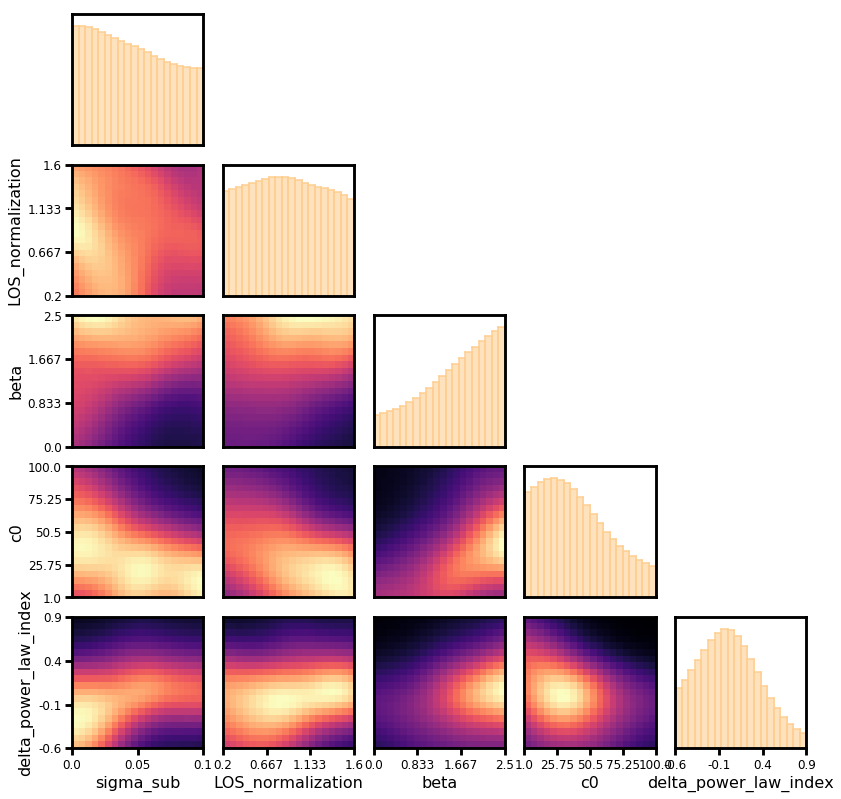

In [8]:
from trikde.triangleplot import TrianglePlot

triangle_plot = TrianglePlot([likelihood])
triangle_plot.set_cmap('magma')
axes = triangle_plot.make_triplot(filled_contours=False, show_intervals=False, show_contours=False
                                 )
# can change axis labels

### The joint likelihood/posterior assuming the slope of the subhalo mass function tracks the slope of the field halo mass function. 

This likelihood has a Gaussian prior on q (see equation for subhalo mass function at the top of this notebook) with a mean of 1 and a variance of 0.25. 

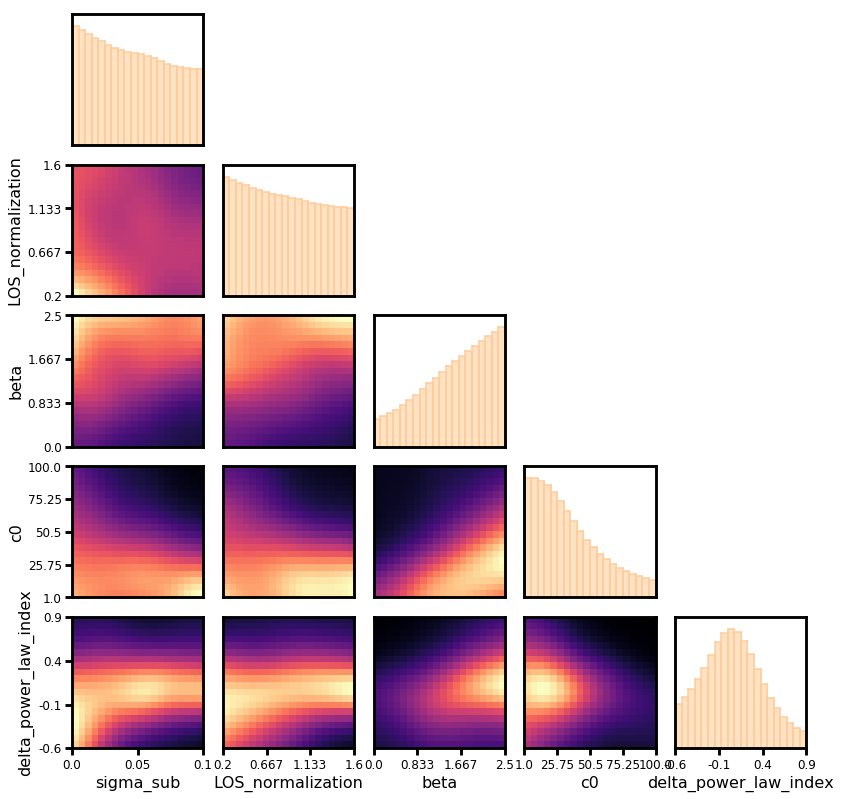

In [9]:
from trikde.triangleplot import TrianglePlot

triangle_plot = TrianglePlot([likelihood_coupled])
triangle_plot.cmap = 'magma'
axes = triangle_plot.make_triplot(filled_contours=False, show_intervals=False, show_contours=False)
# can change axis labels

### The joint likelihood/posterior assuming the slope of the subhalo mass function is completely decoupled from the slope of the field halo mass function. 

This likelihood has a Gaussian prior on q (see equation for subhalo mass function at the top of this notebook) with a mean of 0 and a variance of 0.25. 

/Users/danielgilman/.local/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


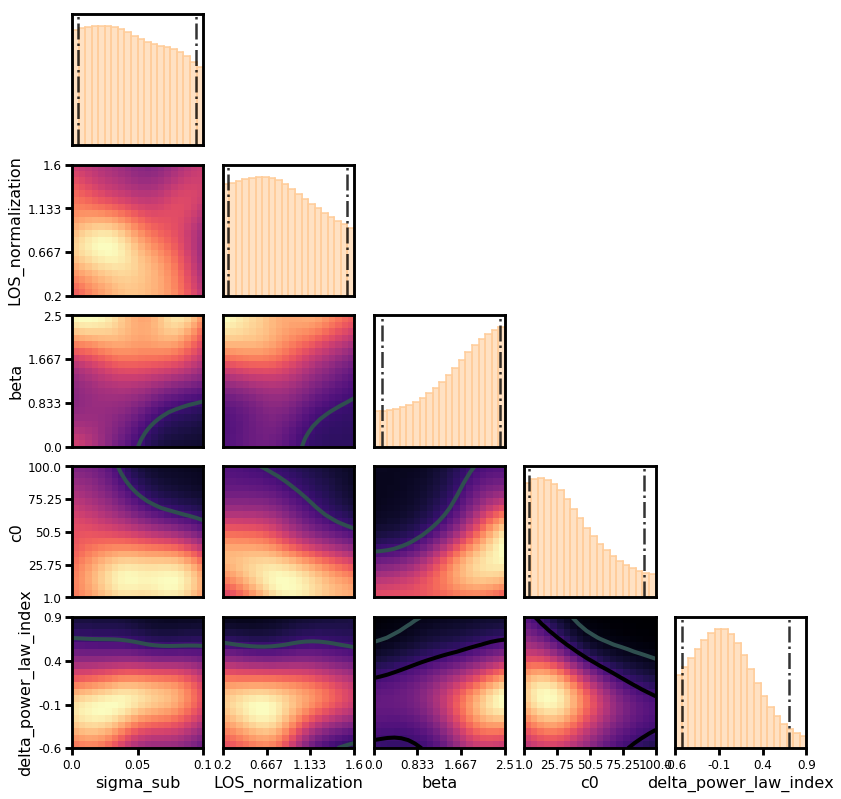

In [10]:
from trikde.triangleplot import TrianglePlot

triangle_plot = TrianglePlot([likelihood_decoupled])
triangle_plot.cmap = 'magma'
axes = triangle_plot.make_triplot(filled_contours=False, show_intervals=True, show_contours=True)
# can change axis labels

### The effect of boxyness and diskyness

The likelihoods displayed above include a marginalization over a parameter $a_4$, which controls the boxyness and diskyness of the macromodel mass profile. We can assess what effect this has on the inference by importance sampling, selecting only realizations with low $a_4$ amplitudes. Black contours show the likelihood with a Gaussian prior on $a_4$ with a mean of 0. and a variance of 0.005, and blue contours show effect of multiplying by a new prior with a mean of 0 and a variance of 0.005. 

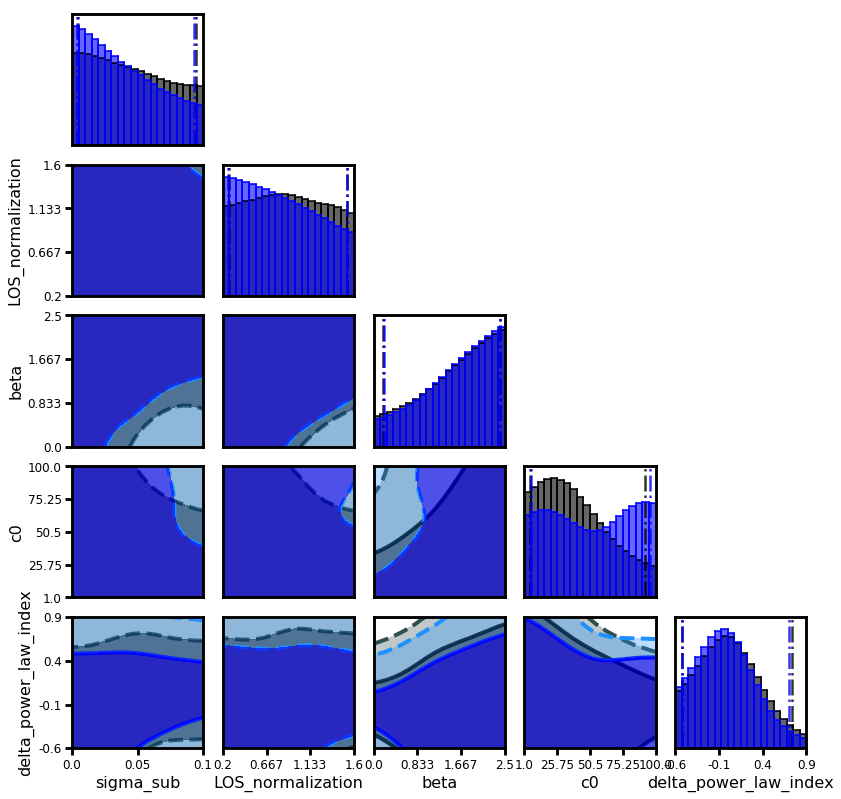

In [11]:
from trikde.triangleplot import TrianglePlot

triangle_plot = TrianglePlot([likelihood, likelihood_lowa4])
triangle_plot.cmap = 'magma'
axes = triangle_plot.make_triplot(filled_contours=True, show_intervals=True, show_contours=True)
# can change axis labels